# Achieve 99.4% (must be consistently shown in last few epochs, and not a one-time achievement) in  less than or equal to 15 Epochs, with less than 10000 Parameters (additional credits for doing this in less than 8000 parameters) and do this in exactly 3 steps!

## Second Attempt:

###### Targets (2nd attempt):
- expect the max Validation Accuracy to reach at least: ~99.2% (i.e. 0.2s in the decimal places)

- The total params in all these attempts has to be under 10K.
###### Results (2nd attempt):
- max Validation Accuracy reached: 99.33% 

- max Train Accuracy reached: 98.95%

- Total params are still : 7,684 (as even with the 2nd attempt, same underlying structure is taken forward)

##### Analysis (2nd attempt):
- Under this 2nd attempt, a torchvision transform is aplied on the images, that randomly rotates an image by a random angle within the range of (-7 degrees, +7 degrees), with the choice made here. The rotation is applied randomly to the image on the specified degree range. For example, if degrees=7 as is the case here, the image will be rotated by a random angle between -7 and 7 degrees. We find that as compared to the first attempt, we have overcome the overfitting a lot and reached test accuracies up to 99.33% while train accuracy still under 99%.

- Hence a scope further opens up for us to try out LR-tuning on top of the same in the next (last) attempt to push things further ahead.

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jan 19 07:36:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Import Libraries

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

### Transforms for the dataset

##### 1. get the mean and std value for the  train data 

In [3]:
# create a simple transform for the dataset with just the
# transforms.ToTensor() part.
simple_transforms = transforms.Compose([
    transforms.ToTensor()
])
# Now create a train_data_set object with only ToTensor as transform
# interface (in non-academic, industrial-setups it is strongly
# recommended to make use of as mucg data to get the mean/std-dev for
# Normalization of data)
train_set_for_mean_std = datasets.MNIST('./data', train=True, download=True,
                                        transform=simple_transforms)
# Get the "ToTensor()-converted", Tensor-format data: For the ToTensor()
# transformed data (the *.data for this dataset is the raw format [0,255]
# range data in Tensor format, but as the ToTensor() transform requires the
# input data to be in ndarray or PIL image format, it needs to be converted
# to ndarray format first, to get the "transformed Tensor format data"
# in this case, the range for Tensor format data is [0,1]
train_data_for_mean_std = train_set_for_mean_std.transform(
    train_set_for_mean_std.data.numpy())
print('\n[Train Dataset---mean and std-dev calculations:]')
print('  \tmin for the train-data', torch.min(train_data_for_mean_std))
print('  \tmax for the train-data', torch.max(train_data_for_mean_std))
print('  \tmean for the train-data',
      round(torch.mean(train_data_for_mean_std).item(), 4))
print('  \tstd for the train-data',
      round(torch.std(train_data_for_mean_std).item(), 4))
train_mean = torch.mean(train_data_for_mean_std).item()
train_std = torch.std(train_data_for_mean_std).item()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw


[Train Dataset---mean and std-dev calculations:]
  	min for the train-data tensor(0.)
  	max for the train-data tensor(1.)
  	mean for the train-data 0.1307
  	std for the train-data 0.3081


##### 2. Test/Train transforms
Here at this 1st attempt,  emphasis is on setting up & stabilizing the infrastructure, for overall training and inference,  while getting an architecture and structure for the neural network right. 

Hence at this stage not looking for any data-augmentation not any learning rate tuning as well.Therefore the train-transform just includes "ToTensor & Normalization steps.And for the learning rate a fixed value lr=0.01 along with momentum=0.9 is used for this 1st attempt.

But having said that, going ahead, will still have to give a closer look to data visualization for choosing on what kind of data-augmentation strategy might help.

In [4]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=7),
    transforms.Normalize((train_mean,), (train_std,))
])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((train_mean,), (train_std,))
])

#### Dataset & creating train/test split

In [5]:
train_set = datasets.MNIST('./data', train=True, download=True,
                           transform=train_transforms)
test_set = datasets.MNIST('./data', train=False, download=True,
                              transform=test_transforms)

 #### Dataloader arguments and train/test dataloaders

In [6]:
# For reproducibility
SEED = 1
cuda = torch.cuda.is_available()
print("Cuda is available?", cuda)
torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)
# dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4,
                           pin_memory=True) if cuda else dict(shuffle=True,
                                                              batch_size=64)
# train/test dataloaders
train_loader = torch.utils.data.DataLoader(train_set, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test_set, **dataloader_args)

Cuda is available? True


#### Data statistics (important to know about the data and stats around it)


[Train]
   	Numpy-Shape: (60000, 28, 28)
   	Tensor-Size: torch.Size([60000, 28, 28])
   	min original raw tensor format data: tensor(0, dtype=torch.uint8)
   	max original raw tensor format data: tensor(255, dtype=torch.uint8)
   	min post-transforms(ToTensor + Normalize) tensor format data: tensor(-0.4241)
   	max post-transforms (ToTensor + Normalize)  tensor format data: tensor(2.8215)
   	mean post-transforms(ToTensor + Normalize) value: -0.42119
   	std post-transforms (ToTensor + Normalize)  tensor format data: tensor(0.0889)
   	var post-transforms (ToTensor + Normalize)  tensor format data: tensor(0.0079)
   	Image shape from the batch: torch.Size([128, 1, 28, 28])
   	Label shape from the batch: torch.Size([128])


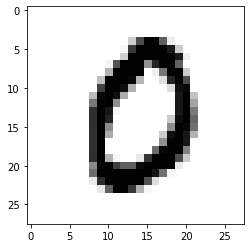

In [7]:
train_data = train_set.transform(train_set.data.numpy())  # for applying
# transforms like transforms.ToTensor(), the format should be
# numpy-ndarray or PIL image.
print('\n[Train]')
print('   \tNumpy-Shape:', train_set.data.cpu().numpy().shape)
print('   \tTensor-Size:', train_set.data.size())
print('   \tmin original raw tensor format data:',
      torch.min(train_set.data))
print('   \tmax original raw tensor format data:',
      torch.max(train_set.data))
print('   \tmin post-transforms(ToTensor + Normalize) tensor format data:',
      torch.min(train_data))
print('   \tmax post-transforms (ToTensor + Normalize)  tensor format data:'
      ,          torch.max(train_data))
print('   \tmean post-transforms(ToTensor + Normalize) value:',
      round(torch.mean(train_data).item(), 5))
print('   \tstd post-transforms (ToTensor + Normalize)  tensor format data:'
      ,          torch.std(train_data))
print('   \tvar post-transforms (ToTensor + Normalize)  tensor format data:'
      ,          torch.var(train_data))
dataiter = iter(train_loader)
images, labels = next(dataiter)
print('   \tImage shape from the batch:', images.shape)
print('   \tLabel shape from the batch:', labels.shape)
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

#### More data visualization (for image augmentation later on)

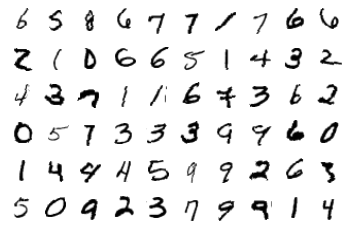

In [8]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

#### The Model

In this 2nd attempt too, the network structure /architecture hasn't changed.
Hence, an architecture as shown in the table below is still chosen as a "baseline" one.Same description as given under the 1st attempt is extended here too.
As while solving the earlier session assignment (and also as covered thoroughly in the last "coding-drill-down" session) two architectural components: BatchNorm & DropOut came out to be two important components to be applied on any Conv2d-layer (except the last one), hence for this session assignment, with very limited number of attempts to go thru (i.e. exactly 3 steps), starting out with inclusion of both these components under this 1st "baseline" neural network architecture (as mentioned before, the excercises on effects of gradual inclusion of both components on neural-net performance, was already undertaken while solving the earlier assignment, hence feel fair enough to start out the first attempt architecture, with both of them included under this new "baseline")

Here is the layering, which is being used to achieve the receptive-field and parameter targets.

Input Channels/Image  |  Conv2d/Transform      | Output Channels | RF
---------------------|--------------|----------------------|----------------------
`28x28x1`              | `(3x3x1)x10`   |      `26x26x10`  |      `3x3`  **INPUT BLOCK** [actually just one conv2d 3x3 layer(image-conv2d layer)]    
` `              | `BN(10)`   |      ` `  |      ` `
` `              | `Dropout(2.9%)`   |      ` `  |      ` `
` `              | `ReLU`   |      ` `  |      ` ` 
`26x26x10`             | `(3x3x10)x10`  |      `24x24x10` |      `5x5`     **CONVOLUTION BLOCK 1** [1st conv2d 3x3 layer for this block ]
` `              | `BN(10)`   |      ` `  |      ` `
` `              | `Dropout(2.9%)`   |      ` `  |      ` `
` `              | `ReLU`   |      ` `  |      ` ` 
`24x24x10`             | `(3x3x10)x15`  |      `22x22x15` |      `7x7`     **CONVOLUTION BLOCK 1** [2nd conv2d 3x3 layer for this block ]
` `              | `BN(15)`   |      ` `  |      ` `
` `              | `Dropout(2.9%)`   |      ` `  |      ` `
` `              | `ReLU`   |      ` `  |      ` ` 
**22x22x15**             |   **MP(2x2)**    |     **11x11x15**   |     **8x8**  **TRANSITION BLOCK 1**  [1st maxpool(2,2) layer for this block]                     
**11x11x15**             | **(1x1x15)x10**  |     **11x11x10**   |      **8x8**  **TRANSITION BLOCK 1**  [2nd 1 conv2d 1x1 layer for this block]  
** **             | **BN(10)**   |     ** **  |     ** **                    
** **             | **Dropout(2.9%)**   |     ** **  |     ** **
** **             | **ReLU**   |     ** **  |     ** **      
*11x11x10*             | *(3x3x10)x10*  |      *9x9x10* |      *12x12*  **CONVOLUTION BLOCK 2** [1st conv2d 3x3 layer for this block]
** **            | *BN(10)*   |     * *   |     * * 
** **             | *Dropout(2.9%)*   |     * *   |     * * 
** **             | *ReLU*   |     ** **  |    ** **                       
*9x9x10*             | *(3x3x10)x10*  |      *7x7x10* |      *16x16*  **CONVOLUTION BLOCK 2** [2nd conv2d 3x3 layer for this block] 
** **            | *BN(16)*   |     * *   |     * * 
** **             | *Dropout(2.9%)*   |     * *   |     * * 
** **             | *ReLU*   |     ** **  |    ** **    
*7x7x10*               | *(3x3x10)x32*  |      *5x5x32*  |      *20x20*  **CONVOLUTION BLOCK 2** [3rd conv2d 3x3 layer for this block, this 32 number of output channels at this stage provides a CAPACITY BOOST for the overall network as explained ahead]  
** **            | *BN(32)*   |     * *   |     * * 
** **             | *Dropout(2.9%)*   |     * *   |     * * 
** **             | *ReLU*   |     ** **  |    ** **   
5x5x32               | GAP  LAYER (kernel_size=(5,5)   |      1x1x32          | `28x28` (20 + (5-1)x2 = 28) **OUTPUT BLOCK** [GAP layer]
`1x1x32`               | `(1x1x32)x10`  |      `1x1x10`    |      `28x28` (28 + (1-1)x10 = 28) **OUTPUT BLOCK** [1 conv2d 1x1 layer]
` `             | `log_SoftMax`   |     ` `  |     ` ` 

 above has 4 "components":
 
 1. **INPUT BLOCK:** One initial, "Input Block" at the begining, to convolve over the "original image"  channel(s), due to the opposing constraints of meeting an accuracy number with lesser parameters possible,
    choosing  10 number of kernels for this 'separate' layer (which feeds in to the next "CONVOLUTION BLOCK 1",
    explained below).This 1 initial layer & two following layers (under "CONVOLUTION BLOCK 1") provide receptive
    field of 7x7 pixels(3->5->7) sufficient for the MNIST dataset's edges & gradient generation.No padding used.    
	
 2. **CONVOLUTION BLOCK 1:** placed after the first "Input Block" layer, 2 layers of 3x3 conv2d operators, with 10 & 15 o/p channels at   each layer position respectively.Thus providing 15 channels at the output.No padding used.
    
 3. **TRANSITION BLOCK 1:** max-pool(k=2,s=2) and a-1x1-feature-merger kernel, following the 'CONVOLUTION BLOCK 1'.Provides 10 o/p channels.No padding used.
    
 4. **CONVOLUTION BLOCK 2:** These are 3 layers of 3x3 conv2d operators, with 10, 10, 32 o/p channels at  each layer position respectively.Here point to be noted, is the use of a "capacity boosting" number of o/p channels at the end. (reason explained in the next point below)
  
 5. **OUTPUT BLOCK:**: GAP layer followed by a 1x1 operator (which actually resembles a fully-connected(FC) layer in this case. A noteworthy point (which relates to the "capacity" element of the overall netowrk (NW)) is that the FC (the 1x1 conv2d behaviour here) will work better, in generating the final 10 "class-features" to be used by the log_softmax.If the inputs to it, have more "features points", i.e. for example if we do a 16->10 conversion, vs a 32->10 conversion, we can expect the 10 class-features (for softmax to decide)      generated by a 32->10 conversion will be more "robust" (as compared to say a 16->10 conversion)
     Forunately, with an already "frugal" choice of numbers like 10, 15 etc, made for earlier layer (and also "frugality" in the total number of layers, which still provide an overall RF as 28, i.e. at least just equal to the original image/object size in this case), we can go ahead with choosing 32 here.

Given below is the number of parameters thus obtained, which is well under 8k.

#####======================= 

> Total params: 7,684

> Trainable params: 7,684

> Non-trainable params: 0
#####--------------------------------------------------

Also please note that out of all the other tested % ranges for dropout, it was found for this NW that 2.9% dropout worked best.


In [9]:
dropout_value = 0.029
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # INPUT "BLOCK" LAYER
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3),
                      padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )  # input_size = 28 output_size = 26 receptive_field = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3),
                      padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )  # input_size = 26 output_size = 24 receptive_field = 5
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=15, kernel_size=(3, 3),
                      padding=0, bias=False),
            nn.BatchNorm2d(15),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )  # input_size = 24 output_size = 22 receptive_field = 7

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2)  # input_size = 22 output_size = 11
        # receptive_field = 8
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(1, 1),
                      padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )  # input_size = 11 output_size = 11 receptive_field = 8

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3),
                      padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )  # input_size = 11 output_size = 9 receptive_field = 12
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3),
                      padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )  # input_size = 9 output_size = 7 receptive_field = 16
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(3, 3),
                      padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )  # input_size = 7 output_size = 5 receptive_field = 20

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        )  # input_size = 5 output_size = 1 receptive_field = 28

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1),
                      padding=0, bias=False),
           # NO BatchNorm/DropOut/ReLU !
        )  # input_size = 1 output_size = 1 receptive_field = 28

    def forward(self, x):
        # INPUT BLOCK LAYER
        x = self.convblock1(x)

        # CONVOLUTION BLOCK 1
        x = self.convblock2(x)
        x = self.convblock3(x)

        # TRANSITION BLOCK 1
        x = self.pool1(x)
        x = self.convblock4(x)

        # CONVOLUTION BLOCK 2
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)

        # OUTPUT BLOCK
        x = self.gap(x)
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

#### Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [10]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
           Dropout-3           [-1, 10, 26, 26]               0
              ReLU-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
       BatchNorm2d-6           [-1, 10, 24, 24]              20
           Dropout-7           [-1, 10, 24, 24]               0
              ReLU-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 15, 22, 22]           1,350
      BatchNorm2d-10           [-1, 15, 22, 22]              30
          Dropout-11           [-1, 15, 22, 22]               0
             ReLU-12           [-1, 15, 22, 22]               0
        MaxPool2d-13           [-1, 15, 11, 11]               0
           Conv2d-14           [-1

#### Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [11]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do
        # backpropragation because PyTorch accumulates the gradients on
        # subsequent backward passes.Because of this, when you start your
        # training loop, ideally you should zero out the gradients so that you
        # do the parameter update correctly.

        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max
        # log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(
            desc=f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100 * correct / processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target,
                                    reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1,
                                 keepdim=True)  # get the index of the max
            # log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

#### Let's Train and test our model

In [12]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.20462565124034882 Batch_id=468 Accuracy=83.45: 100%|██████████| 469/469 [00:14<00:00, 31.55it/s]



Test set: Average loss: 0.1229, Accuracy: 9702/10000 (97.02%)

EPOCH: 1


Loss=0.08135145157575607 Batch_id=468 Accuracy=97.48: 100%|██████████| 469/469 [00:15<00:00, 30.12it/s]



Test set: Average loss: 0.0743, Accuracy: 9800/10000 (98.00%)

EPOCH: 2


Loss=0.04653613641858101 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:15<00:00, 31.19it/s]



Test set: Average loss: 0.0456, Accuracy: 9867/10000 (98.67%)

EPOCH: 3


Loss=0.07140930742025375 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:14<00:00, 31.33it/s]



Test set: Average loss: 0.0431, Accuracy: 9872/10000 (98.72%)

EPOCH: 4


Loss=0.12385015934705734 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:14<00:00, 31.89it/s]



Test set: Average loss: 0.0365, Accuracy: 9887/10000 (98.87%)

EPOCH: 5


Loss=0.019117845222353935 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:14<00:00, 31.34it/s]



Test set: Average loss: 0.0310, Accuracy: 9918/10000 (99.18%)

EPOCH: 6


Loss=0.03349563851952553 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:14<00:00, 31.72it/s]



Test set: Average loss: 0.0323, Accuracy: 9893/10000 (98.93%)

EPOCH: 7


Loss=0.013932176865637302 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:15<00:00, 31.18it/s]



Test set: Average loss: 0.0312, Accuracy: 9906/10000 (99.06%)

EPOCH: 8


Loss=0.03439395874738693 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:14<00:00, 31.57it/s]



Test set: Average loss: 0.0305, Accuracy: 9908/10000 (99.08%)

EPOCH: 9


Loss=0.07354197651147842 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:15<00:00, 31.05it/s]



Test set: Average loss: 0.0275, Accuracy: 9923/10000 (99.23%)

EPOCH: 10


Loss=0.04493391886353493 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:14<00:00, 31.75it/s]



Test set: Average loss: 0.0257, Accuracy: 9925/10000 (99.25%)

EPOCH: 11


Loss=0.06320219486951828 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:14<00:00, 31.54it/s]



Test set: Average loss: 0.0241, Accuracy: 9933/10000 (99.33%)

EPOCH: 12


Loss=0.03458494693040848 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:14<00:00, 31.55it/s]



Test set: Average loss: 0.0266, Accuracy: 9913/10000 (99.13%)

EPOCH: 13


Loss=0.013233151286840439 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:14<00:00, 31.35it/s]



Test set: Average loss: 0.0238, Accuracy: 9925/10000 (99.25%)

EPOCH: 14


Loss=0.029584722593426704 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:15<00:00, 30.38it/s]



Test set: Average loss: 0.0220, Accuracy: 9933/10000 (99.33%)



Text(0.5, 1.0, 'Test Accuracy')

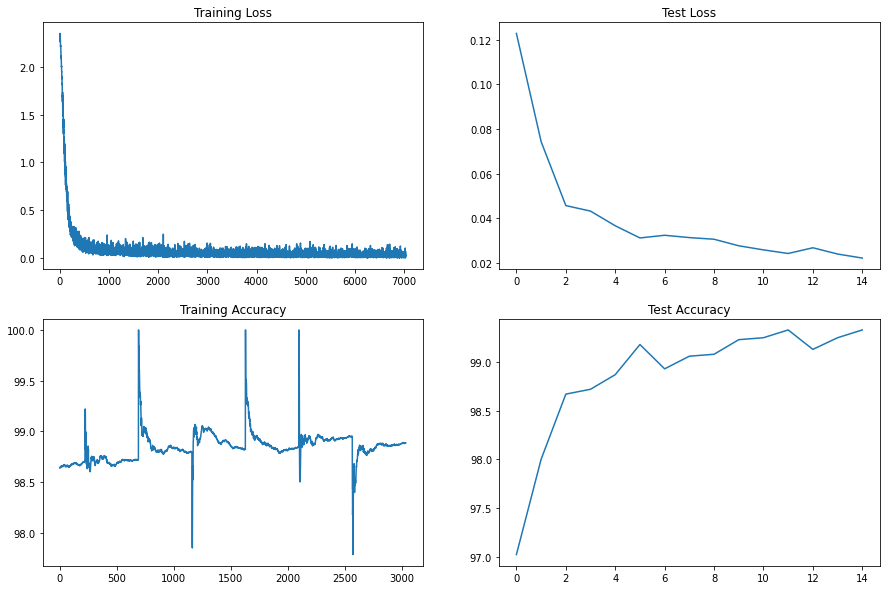

In [13]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
trn_loss= [t.cpu().item() for t in train_losses]
axs[0, 0].plot(trn_loss)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")